<a href="https://colab.research.google.com/github/camilomarino/DLBioIm/blob/main/Pr%C3%A1ctica_3_Medical_Camilo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 3: Redes neuronales convolucionales para clasificación de imágenes histopatológicas

En esta práctica, vamos a utilizar modelos profundos para clasificar imágenes histopatológicas de muestras de cancer colorectal. En este caso, utilizaremos el dataset PathMNIST de MedMNISTv2, que contiene imágenes histopatológicas de tamaño reducido (28x28, con 3 canales de color RGB), correspondientes a 9 clases diferentes de tejidos. 

Las posibles clases son:

* '0': 'adipose'
* '1': 'background'
* '2': 'debris'
* '3': 'lymphocytes'
* '4': 'mucus'
* '5': 'smooth muscle'
* '6': 'normal colon mucosa'
* '7': 'cancer-associated stroma'
* '8': 'colorectal adenocarcinoma epithelium'

Para más información sobre MedMNISTv2 y el dataset utilizado, ver el paper asociado ( https://arxiv.org/pdf/2110.14795.pdf ) o el sitio web del proyecto: https://medmnist.com/

Vamos a comenzar por descargar y visualizar el dataset:

In [1]:
pip install medmnist

     |████████████████████████████████| 87 kB 5.3 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=405b936613e1c607440b71a130eda844f0b6f996e01adfcf65aaea1f7efaf7fe
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import medmnist
from medmnist import INFO, Evaluator

data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# Creando los datasets
Ahora procederemos a crear los datasets con las imágenes de training y de test. Aquí por simplicidad no utilizaremos la partición de validación, pero recordar que siempre se debe contar con una partición de validación para la selección de hiperparámetros y de modelo.

In [3]:
# Tamaño del batch de entrenamiento que será utilizado al generar los dataloaders
BATCH_SIZE = 128

# Transformaciones que serán utilizadas para normalizar las imagenes
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Creo los datasets
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Dataset que será utilizado solo para vbisualización (no incluye las transformaciones)
visual_dataset = DataClass(split='train', download=download)

# Encapsulo los datasets en un dataloader
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)




  0%|          | 0/205615438 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


# Visualizando las imágenes

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


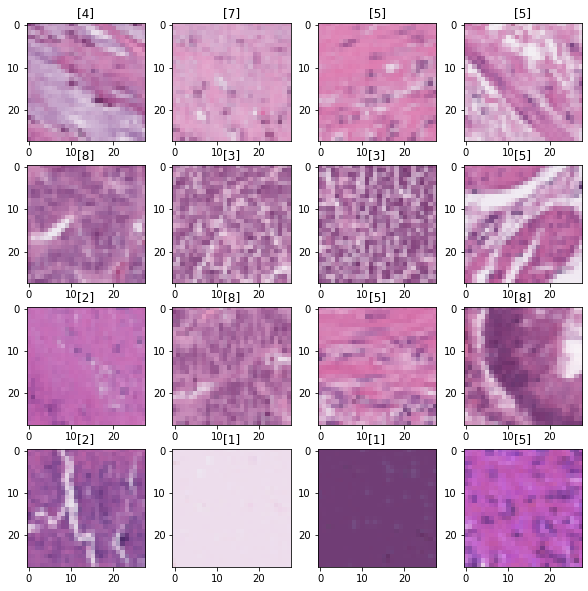

In [4]:
# Visualizamos algunas imágenes de ejemplo con sus etiquetas
offset = 0
plt.rcParams['figure.figsize'] = [10, 10]

for i in range(1+offset,17+offset):
    plt.subplot(4,4,i-offset)
    img = visual_dataset[i][0]
    lbl = visual_dataset[i][1]
    plt.imshow(img)
    plt.title(lbl)

print("Labels: " + str(train_dataset.info['label']))




# Perceptrón multicapa

Primero, vamos a adaptar el perceptrón mutlicapa implementado en la práctica anterior, para que pueda clasificar imágenes de 28 x 28 en 9 categorías diferentes. Para ello, deberemos realizar algunos cambios:

* Antes de procesar la imagen, deberemos reformatearla para que pase de ser una imagen de 28 x 28 x 3, a un vector de 2352 componetes. Para ello, utilziaremos el método `view` de los tensores de Pytorch.

* Utilizaremos un perceptrón con 15 neuronas en las capas intermedias.

* La última capa deberá tener 9 neuronas (en lugar de 1 sola como tenia el perceptrón multicapa que utilizamos para hacer regresión).

* Deberemos cambiar la función de pérdida. En este caso, utilizaremos Entropía Cruzada (`torch.nn.CrossEntropyLoss`)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

class NetMLP(torch.nn.Module):
    def __init__(self, input_features, size_hidden, n_output):
        super().__init__()
        self.hidden1 = nn.Linear(input_features, size_hidden)
        self.hidden2 = nn.Linear(size_hidden, size_hidden)
        self.out = nn.Linear(size_hidden, n_output)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.hidden1(x)
        x = F.relu(x)
        x = self.hidden2(x)
        x = F.relu(x)
        x = self.out(x)
        return x

Y ahora entrenamos el modelo

Epoch : 0


100%|██████████| 704/704 [00:22<00:00, 31.62it/s]


Epoch 0, Avg train loss during epoch = 1.81321
Epoch : 1


100%|██████████| 704/704 [00:22<00:00, 31.58it/s]


Epoch 1, Avg train loss during epoch = 1.5878
Epoch : 2


100%|██████████| 704/704 [00:22<00:00, 31.24it/s]

Epoch 2, Avg train loss during epoch = 1.52861


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

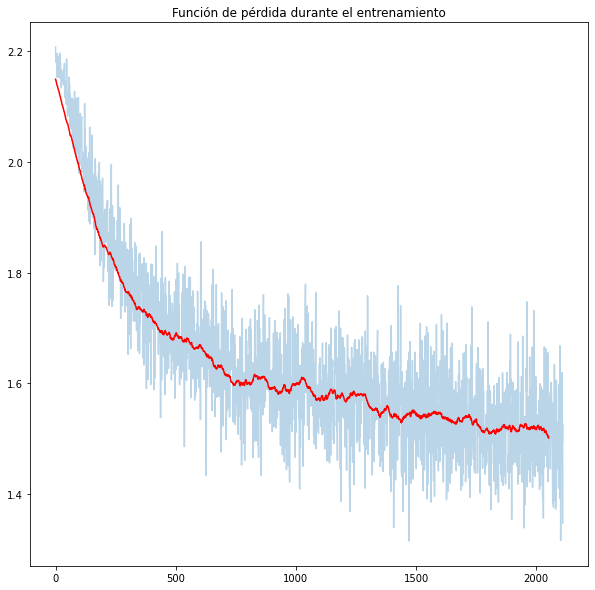

In [6]:
# Definimos el modelo del perceptrón
input_features = 28*28*3 # Se multiplica por 3 porque tenemos 3 canales de color (RGB) de 28x28
hidden_neurons = 15

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 0.0001

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device('cuda:0')

net = NetMLP(input_features, hidden_neurons, n_classes)
net.to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar 
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = nn.CrossEntropyLoss()

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).

# Número de épocas
num_epochs = 3

# Lista en la que iremos guardando el valor de la función de pérdida en cada 
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):
    print("Epoch : " + str(i))
    # Itero sobre todos los batches del dataset
    loss_list_epoch = []
    for x, y in tqdm(train_loader):
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)
        y = y.squeeze().long()

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)
        
        # Realizo la pasada backward por la red        
        loss.backward()
        
        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

        loss_list_epoch.append(loss.data.item())
    # Muestro el valor de la función de pérdida cada 100 iteraciones        
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, Avg train loss during epoch = %g' % (i, np.array(loss_list_epoch).mean()))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")


### Guardamos el modelo para poder reutilizarlo

In [7]:
torch.save(net.state_dict(), "./mlp.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [8]:
# Cargo el modelo guardado (si el modelo se encuentra en memoria, este paso no es necesario)
net = NetMLP(input_features,hidden_neurons,n_classes)
net.load_state_dict(torch.load("./mlp.pth"))
net.to(device)

NetMLP(
  (hidden1): Linear(in_features=2352, out_features=15, bias=True)
  (hidden2): Linear(in_features=15, out_features=15, bias=True)
  (out): Linear(in_features=15, out_features=9, bias=True)
)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.94      0.98      0.96        62
           1       0.96      0.93      0.94        27
           2       0.17      0.17      0.17        12
           3       0.17      0.17      0.17        24
           4       0.58      0.65      0.61        40
           5       0.15      0.36      0.21        14
           6       0.00      0.00      0.00        20
           7       0.00      0.00      0.00        15
           8       0.49      0.60      0.54        42

    accuracy                           0.58       256
   macro avg       0.38      0.43      0.40       256
weighted avg       0.53      0.58      0.55       256



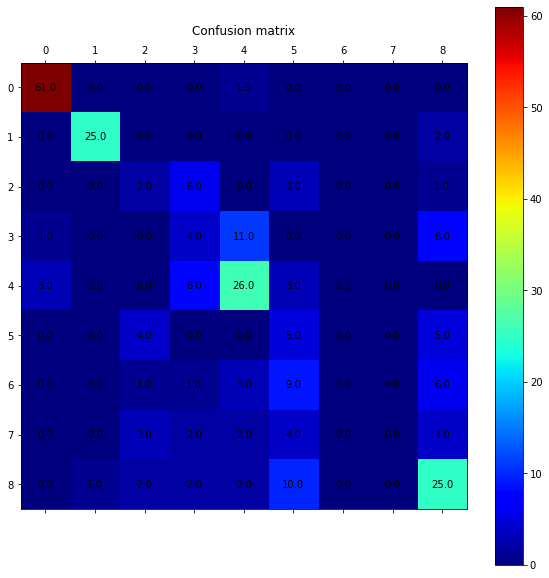

In [9]:
def showTestResults(model):
  plt.rcParams['figure.figsize'] = [12, 10]
  from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

  # Genero un data loader para leer los datos de test 
  x_test = list(test_loader)[0][0]
  y_test = list(test_loader)[0][1]

  # Muevo los tensores a la GPU
  x_test = x_test.to(device)

  # Realizo las predicciones del modelo
  pred = model(x_test)

  # Extraigo el índice de la predicción con mayor valor para decidir la clase asignada
  pred_y = torch.max(pred.to("cpu"), 1)[1].data.numpy()

  # Imprimo el reporte de clasificación (accuracy, etc)
  print(classification_report(y_test, pred_y))

  # Computo la matriz de confusión y la muestro
  conf_mat = confusion_matrix(y_test, pred_y)
  plt.matshow(conf_mat, cmap='jet')

  for (i, j), z in np.ndenumerate(conf_mat):
      plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
      
  plt.title("Confusion matrix")
  plt.colorbar()

showTestResults(net)

# Red Neuronal Convolucional

También definiremos un modelo NetCNN que implemente una red neuronal convolucional, el cual seguirá la siguiente estructura:
* Capa convolucional (6 feature maps de salida) + ReLU
* Max pooling 2 x 2
* Capa convolucional (16 feature maps de salida) + ReLU
* Max pooling 2 x 2
* Capa totalmente conectada (120 neuronas) + ReLU
* Capa totalmente conectada (84 neuronas) + ReLU
* Capa de salida (10 neuronas)

Notar que utilizaremos la función `CrossEntropyLoss` para entrenar el modelo. Recordar que dados:
* F: tamaño del filtro
* W: Tamaño del feature map de entrada
* P: Padding
* S: Stride

El tamaño de la salida es $O = \frac{(W - F + 2P)}{S} + 1$


In [21]:
class NetCNN(nn.Module):

    def __init__(self):
        super(NetCNN, self).__init__()
        # 3 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1) 
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 9)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.conv1(x) # batch_size x 6 x 28 x 28
        x = F.relu(x) # batch_size x 6 x 28 x 28
        x = F.max_pool2d(x, kernel_size=2) # batch_size x 6 x 14 x 14
        x = self.conv2(x) # batch_size x 16 x 14 x14
        x = F.relu(x) # batch_size x 16 x 14 x 14
        x = F.max_pool2d(x, kernel_size=2) # batch_size x 16 x 7 x 7

        x = x.view(x.size(0), -1) # batch_size x 16*7*7
        x = self.fc1(x) # batch_size x 120
        x = self.fc2(x) # batch_size x 84
        x = self.fc3(x) # batch_size x 9

        return x

100%|██████████| 704/704 [00:27<00:00, 25.40it/s]


Epoch 0, Avg train loss during epoch = 1.59917


100%|██████████| 704/704 [00:25<00:00, 27.81it/s]


Epoch 1, Avg train loss during epoch = 1.17814


100%|██████████| 704/704 [00:26<00:00, 26.14it/s]


Epoch 2, Avg train loss during epoch = 1.02475


Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

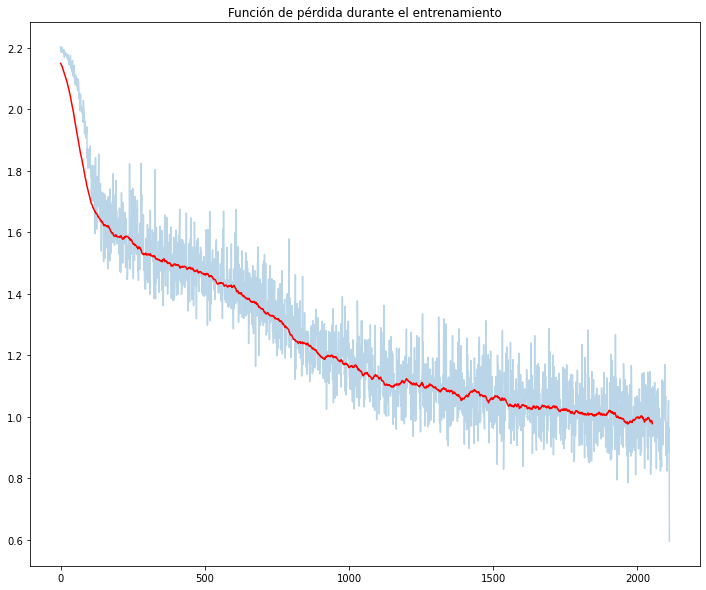

In [22]:
# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 0.0001

# Dispositivo en que se ejecturá el modelo: 'cuda:0' para GPU y 'cpu' para CPU
device = torch.device('cuda:0')

net = NetCNN()
net.to(device)

# Construimos el optimizador, y le indicamos que los parámetros a optimizar 
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = torch.nn.CrossEntropyLoss() 

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).

# Número de épocas
num_epochs = 3

# Lista en la que iremos guardando el valor de la función de pérdida en cada 
# etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):
    loss_list_epoch = []
    # Itero sobre todos los batches del dataset
    for x, y in tqdm(train_loader):

        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Movemos los tensores a memoria de GPU
        x = x.to(device)
        y = y.to(device)
        y = y.squeeze().long()

        # Realizo la pasada forward por la red
        loss = criterion(net(x), y)
        
        # Realizo la pasada backward por la red        
        loss.backward()
        
        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())
        loss_list_epoch.append(loss.data.item())

    # Muestro el valor de la función de pérdida cada 100 iteraciones        
    #if i > 0 and i % 100 == 0:
    print('Epoch %d, Avg train loss during epoch = %g' % (i, np.array(loss_list_epoch).mean()))


# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")


### Guardo el modelo

In [23]:
torch.save(net.state_dict(), "./cnn.pth")

#### Cargamos el modelo y visualizamos los resultados en los datos de test

Para ello, utilizaremos los métodos `classification_report` y `confusion_matrix` de scikitlearn.

In [24]:
# Cargamos el modelo (no es necesario si el modelo se encuentra en memoria)
net = NetCNN()
net.load_state_dict(torch.load("./cnn.pth"))
net.to(device)

NetCNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93        62
           1       0.82      1.00      0.90        27
           2       0.08      0.08      0.08        12
           3       0.42      0.42      0.42        24
           4       0.47      0.45      0.46        40
           5       0.43      0.43      0.43        14
           6       0.62      0.50      0.56        20
           7       0.33      0.20      0.25        15
           8       0.72      0.81      0.76        42

    accuracy                           0.65       256
   macro avg       0.54      0.54      0.53       256
weighted avg       0.64      0.65      0.64       256



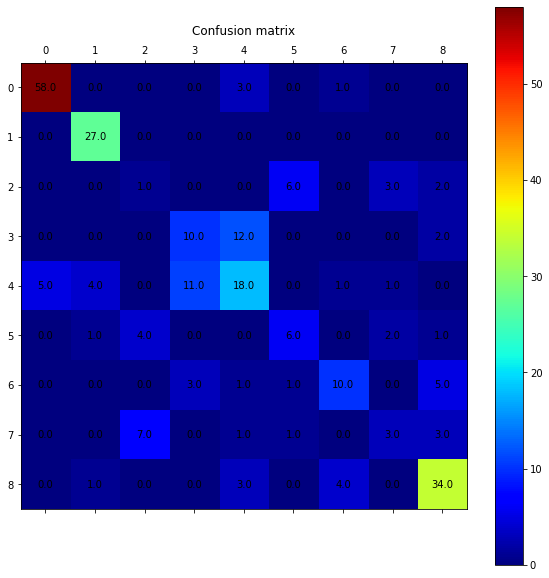

In [25]:
# Mostramos los resultados
showTestResults(net)

# Entregable

1. Implementar el perceptrón multicapa y la red neuronal convolucional solicitadas.

2. Para el caso de la red neuronal convolucional, realizar el cálculo del tamaño de la entrada y salida en cada capa convolucional en función de los parámetros de cada capa (tamaño del kernel, padding, stride, etc) para garantizar que los tensores que fluyen por la red sean del tamaño adecuado. Indicar el tamaño de los feature maps a medida que fluyen por la red.

3. Comparar la accuracy obtenida par el perceptrón muticapa y la red neuronal convolucional. Observar qué sucede al incrementar la cantidad de épocas de entrenamiento.
